# Setup

In [1]:
%pip install dill
%pip install pyreadr
%pip install scikit-learn
%pip install pandas
%pip install numpy==2.1.0
%pip install xgboost
%pip install matplotlib
%pip install seaborn
%pip install typeguard
%pip install PyQt6
%pip install smogn
%pip install seaborn
%pip install imbalanced-learn
%pip install shap
%pip install numba


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: imbalanced-learn in c:\users\kevin\dev\ml_research\venv\lib\site-packages (0.13.0)




[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Library to check function types of imported modules
from typeguard import install_import_hook

# Data import and export
import pyreadr
import dill

# Data management libraries

import pandas as pd
import numpy as np
from scipy.stats import pearsonr, percentileofscore

# Plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Model training and evaluation
import shap

# Miscellaneous
import os
import xgboost as xgb

# Preprocessing
from smogn import smoter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

# K-fold cross-validation
from sklearn.model_selection import KFold

# Custom functions for plotting, data operations, and model training
with install_import_hook('custom_ml_plots'):
    import custom_ml_plots as cmp
with install_import_hook('custom_dataset_tools'):
    import custom_dataset_tools as cdt
with install_import_hook('basic_ml_operations'):
    import basic_ml_operations as bmo
with install_import_hook('ml_data_objects'):
    import ml_data_objects as mdo
with install_import_hook('pandas_relational_algebra'):
    import pandas_relational_algebra as pra

# Global parameters
RANDOM_STATE = 42
TOP_THRESHOLD_QUANTILE = 0.8  # Values to test: 0.5, 0.6, 0.7, 0.8, 0.9
SMOGN_PREPROCESS = True
UNDERSAMPLE = True
SHAP = False # Set to True to run SHAP analysis


c:\Users\kevin\dev\ml_research\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dill session
dill.load_session(r"C:\Users\kevin\dev\ml_research\saved_data_and_plots\thresh_0.8_undersample_False\project_ipynb_env_RO.db")

## Setup Plotting Functions

In [4]:
def plot_shaded_scatter_grids(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, pearson_grid: np.ndarray, plot_title: str) -> plt.Figure:
    """
    Plot predictions vs actuals and colour by pearson coefficient and add best fit
    Created: 2024/11/30

    Args:
        y_preds_grid (np.ndarray): 2D array of predicted values from different models.
        y_test_grid (np.ndarray): 2D array of actual values corresponding to the predictions.
        axis1_params (mdo.AxisParams): Hyperparameters for the first axis.
        axis2_params (mdo.AxisParams): Hyperparameters for the second axis.
        pearson_grid (np.ndarray): 2D array of Pearson coefficients for each model.
        plot_title (str): Title of the plot.

    Returns:
        plt.Figure: The resulting figure object containing the scatter plots.
    """
    # Create a grid of scatter plots with predictions vs actuals
    fig, axs = cmp.create_scatter_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, plot_title)

    # Color the scatter plots by Pearson coefficient and add best fit lines and title
    cmp.color_spectrum(fig, axs, pearson_grid, label="Pearson Coefficient")
    cmp.add_best_fit(axs)

    return fig

In [5]:
def plot_shaded_roc_grids(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, f1_grid: np.ndarray, plot_title: str) -> plt.Figure:
    """
    Plot predictions vs actuals and colour by f1 score and add best fit
    Created: 2024/12/22

    Args:
        y_preds_grid (np.ndarray): 2D array of predicted probabilities from different models.
        y_test_grid (np.ndarray): 2D array of actual binary values corresponding to the predictions.
        axis1_params (mdo.AxisParams): Hyperparameters for the first axis.
        axis2_params (mdo.AxisParams): Hyperparameters for the second axis.
        f1_grid (np.ndarray): 2D array of F1 scores for each model.
        plot_title (str): Title of the plot.

    Returns:
        plt.Figure: The resulting figure object containing the ROC plots.
    """
    # Create a grid of ROC plots with predictions vs actuals
    fig, axs = cmp.create_roc_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, plot_title)

    # Color the ROC plots by F1 score and add best fit lines and title
    cmp.color_spectrum(fig, axs, f1_grid, label="F1 Score")
    
    return fig

In [6]:
# Stores average metrics for each model for final comparison
# See Montesinos-Lopez research paper and README for details on metrics and the different models
B_average_metrics = pd.DataFrame(columns=['F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])
R_average_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])
RO_average_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

# Add existing GBLUP regression model data from Montesinos-Lopez paper
B_average_metrics.loc['GBLUP'] =  [0.411, 0.696, 0.577, 0.180]
R_average_metrics.loc['GBLUP'] =  [None, 0.215, 0.128, 0.987, 0.164]
RO_average_metrics.loc['GBLUP'] = [None, 0.487, 0.711, 0.699, 0.304]

In [7]:
def histogram(data: pd.DataFrame, title: str, x_ax_label: str = 'Grain Yield (GY)', y_ax_label: str = 'Frequency', vline_value: float = None) -> None:
    """
    Create a stacked histogram of grain yield values for each column in the DataFrame.
    Created: 2024/01/12

    Args:
        data (pd.DataFrame): DataFrame containing values; can have multiple columns for a stacked histogram
        title (str): Title of the plot
        x_ax_label (str): Label for the x-axis (default is 'Grain Yield (GY)')
        y_ax_label (str): Label for the y-axis (default is 'Frequency')
        vline_value (float, optional): Value at which to draw a dotted red vertical line (default is None)
    """
    # Plot stacked histogram for each column in the DataFrame
    data.plot.hist(stacked=True, bins=60, edgecolor='black', alpha=0.7)

    # Add labels for x-axis and y-axis
    plt.xlabel(x_ax_label)
    plt.ylabel(y_ax_label)
    
    # Add title to the plot
    plt.title(title)
    
    # Draw a dotted red vertical line if vline_value is specified
    if vline_value is not None:
        plt.axvline(x=vline_value, color='red', linestyle='--', linewidth=1.5)
    
    # Save the plot as an SVG file in the specified storage directory
    plt.savefig(f'{storage_dir}\\{title}.svg', format="svg")
    
    # Display the plot
    plt.show()
    
    # Close the plot to free up memory
    plt.close()


## Import Data

In [8]:
def create_numbered_subdir():
    """
    Creates a new subdirectory within the 'saved_data_and_plots' directory, 
    with a name that is the next available number in sequence, formatted as a 
    three-digit number (e.g., '001', '002', etc.).
    Created: 2024/01/01
    Returns:
        str: The path to the newly created numbered subdirectory.
    """
    # Define the parent directory where subdirectories will be created
    parent_dir = "saved_data_and_plots"
    
    # Create parent directory if it doesn't exist
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
    
    # List all existing directories within the parent directory
    existing_dirs = [d for d in os.listdir(parent_dir) 
                    if os.path.isdir(os.path.join(parent_dir, d))]
    
    # Extract numeric values from directory names and find the next available number
    existing_nums = [int(d) for d in existing_dirs if d.isdigit()]
    next_num = max(existing_nums + [-1]) + 1
    
    # Create the new numbered directory with the next available number
    new_dir = os.path.join(parent_dir, f"{next_num:03d}")
    os.makedirs(new_dir)
    
    # Return the path to the newly created directory
    return new_dir

# Create a new numbered subdirectory and store its path in the variable 'storage_dir'
storage_dir = create_numbered_subdir()

,GY
GID,
GID6569128,6.119272
GID6569128,5.905515
GID6569128,2.160587
GID6569128,6.456711
GID6688880,3.616688


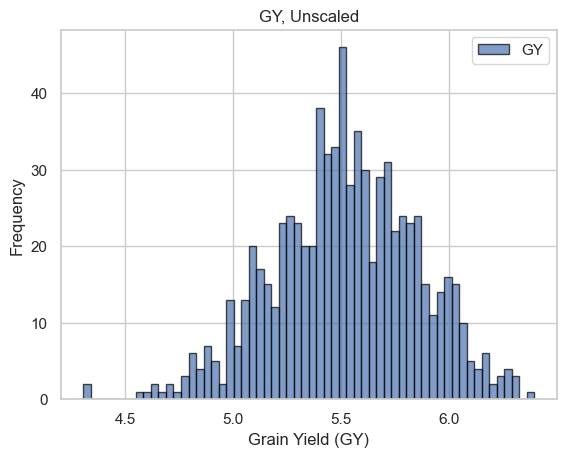

,GY
count,766.000000
mean,5.517416
std,0.333979
min,4.305651
25%,5.301989
50%,5.517454
75%,5.748336
max,6.394285


In [9]:
# Import dataset
eyt1 = pyreadr.read_r('./data/eyt1.RData')

# Extract training example labels
y = eyt1['Pheno_Disc_Env1'][['GY']]

# Set index to gene IDs and sort by index
y = y.set_index(eyt1['Pheno_Disc_Env1']['GID'])
y = y.sort_index()

# Display the first few rows of the dataset
display(y.head())

# Check for missing values
cdt.assert_no_bad_values(y)

# Each seed was planted in 4 different environments, but we don't care about environmental differences
# So we take the average of every group of four rows to reduce the dataset to 1/4 its original size
y = cdt.avg_rows(y, 4)

# Plot histogram of grain yield values
histogram(y, 'GY, Unscaled')

# Display summary statistics of the dataset
y.describe()


In [10]:
# Extract the feature matrix and set the index to match y
X = eyt1['Geno_Env1'].sort_index()

# Display the feature matrix
display(X)

# Reset the index for both X and y to ensure they match
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

,GID6569128,GID6688880,GID6688916,GID6688933,GID6688934,GID6688949,GID6689407,GID6689482,GID6689550,GID6738288,...,GID6939899,GID6939900,GID6939902,GID6939903,GID6939904,GID6939917,GID6939919,GID6939938,GID6939941,GID6939945
GID6569128,0.788801,-0.006443,0.025987,-0.138795,-0.157880,0.096213,-0.110899,0.013069,-0.040445,0.007931,...,0.125612,0.133808,0.137456,0.127674,0.130468,0.004096,0.091188,0.074009,0.032992,0.199459
GID6688880,-0.006443,0.980542,0.064585,-0.168773,-0.081006,0.078890,-0.201346,0.124671,0.253505,0.013636,...,0.072171,0.061650,0.057898,0.079085,0.061086,0.104630,0.113878,0.108757,0.154718,0.004447
GID6688916,0.025987,0.064585,1.170073,-0.021636,-0.031717,0.101532,-0.196780,0.041900,-0.013459,0.126464,...,0.428609,0.423184,0.427788,0.408326,0.426844,0.006038,0.209395,0.240468,0.255337,0.163524
GID6688933,-0.138795,-0.168773,-0.021636,0.879004,0.443678,-0.080560,0.402479,-0.218803,-0.102718,-0.002303,...,-0.079312,-0.087824,-0.089912,-0.067028,-0.084206,-0.140529,-0.088961,-0.096740,-0.159136,-0.108800
GID6688934,-0.157880,-0.081006,-0.031717,0.443678,0.996666,-0.140766,0.395843,-0.310471,-0.138902,0.088169,...,-0.016690,-0.017375,-0.026372,-0.014478,-0.016350,-0.098509,-0.052304,-0.012778,-0.100318,-0.154557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GID6939917,0.004096,0.104630,0.006038,-0.140529,-0.098509,0.048248,-0.114305,0.062388,0.060255,0.034630,...,0.144931,0.144932,0.155032,0.150037,0.161459,1.112390,0.077593,0.107666,0.121171,0.087428
GID6939919,0.091188,0.113878,0.209395,-0.088961,-0.052304,0.139241,-0.141205,0.184798,0.070163,0.015030,...,0.255040,0.249602,0.262775,0.242206,0.253641,0.077593,0.986131,0.159823,0.380622,0.167608
GID6939938,0.074009,0.108757,0.240468,-0.096740,-0.012778,0.058980,-0.149919,0.000392,0.063573,0.090066,...,0.719743,0.728707,0.732558,0.708062,0.704652,0.107666,0.159823,1.118190,0.388284,0.389739
GID6939941,0.032992,0.154718,0.255337,-0.159136,-0.100318,0.045545,-0.206353,0.194754,0.043889,0.084022,...,0.465269,0.461691,0.473004,0.432339,0.435412,0.121171,0.380622,0.388284,1.070441,0.219306


In [11]:
def scale_features_and_target(X: pd.DataFrame, y: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, StandardScaler, StandardScaler):
    """
    Scale the feature matrix and target values using StandardScaler.

    Created: 2024/01/01
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.DataFrame): Target values.
    
    Returns:
        X_sc (pd.DataFrame): Scaled feature matrix.
        y_sc (pd.DataFrame): Scaled target values.
        X_scaler (StandardScaler): Scaler used for features.
        y_scaler (StandardScaler): Scaler used for target.
        
    """
    X_sc, y_sc, X_scaler, y_scaler = None, None, None, None

    # Scale the feature matrix
    if X is not None:
        X_scaler = StandardScaler()
        X_sc = X_scaler.fit_transform(X)
        X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

    # Scale the target values
    if y is not None:
        y_scaler = StandardScaler()
        y_sc = y_scaler.fit_transform(y)
        y_sc = pd.DataFrame(y_sc, index=y.index, columns=y.columns)
    
    return X_sc, y_sc, X_scaler, y_scaler

In [12]:
def smogn_prep(X: pd.DataFrame, y: pd.DataFrame, top_threshold_quantile: float, undersample: bool = True) -> None:
    """
    Preprocesses the dataset using the SMOGN algorithm
    Created: 2024/02/05

    Args:
        X (pd.DataFrame): Feature matrix
        y (pd.DataFrame): DataFrame containing grain yield values
        top_threshold_quantile (float): The quantile value to use as the threshold for the top class
        undersample (bool): Whether to undersample the majority class (default is True)
    """

    # Temporarily combine X and y for compatibility with the SMOGN library
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    smogn_X_y = pd.concat([X, y], axis=1)

    # Get GY distribution points
    gy_min = y['GY'].min()
    gy_max = y['GY'].max()
    gy_just_under_threshold = y['GY'].quantile(top_threshold_quantile - 0.0001)
    gy_just_over_threshold = y['GY'].quantile(top_threshold_quantile + 0.0001)

    # Define control points for the SMOGN augmentation relevance function
    ctrl_points = [
        [gy_min, 0, 0],
        [gy_just_under_threshold, 0, 0],
        [gy_just_over_threshold, 1, 0],
        [gy_max, 1, 0]
    ]

    # Display the combined DataFrame
    display(smogn_X_y)

    n_tries = 0
    done = False

    # Unfortunately the library has a bug where it randomly throws exceptions occasionally regardless of input
    # So we have to try multiple times until it works... this is hacky but it will have to do until the library is fixed
    while not done:
        try:
            # Apply the SMOGN algorithm to balance the dataset
            X = smoter(
                data=smogn_X_y,
                y='GY',
                k=5,
                under_samp=undersample,
                samp_method='balance',
                rel_thres=top_threshold_quantile,
                rel_method='manual',
                rel_ctrl_pts_rg=ctrl_points,
                rel_xtrm_type='high',
                rel_coef=1.50
            )
            done = True

        except ValueError:
            if n_tries < 5:
                n_tries += 1
            else:
                raise

    # Split X and y back into separate DataFrames
    y = X[['GY']]
    X = X.drop(columns=['GY'])

    return X, y

In [13]:
# Identify the cutoff value for the "Top Line" classification of grain yield values
top_boundary_val = y["GY"].quantile(TOP_THRESHOLD_QUANTILE)

# Model R

In [14]:
def inner_CV_R(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, 
               train_model_callback, kfold_random_state: int, plot_title: str = "", **kwargs):
    """Perform inner cross-validation with grid search to find the best model parameters.
    Created: 2024/12/03
    Parameters:
    -----------
    n_splits : int
        Number of splits for KFold cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Parameter grid for the first axis.
    axis2_params : mdo.AxisParams
        Parameter grid for the second axis.
    train_model_callback : callable
        Callback function to train the model.
    kfold_random_state : int
        Random state for KFold shuffling.
    plot_title : str, optional
        Title for the plot (default is "").
    **kwargs : dict
        Additional keyword arguments for the model training.
    Returns:
    --------
    avg_best_param1 : float
        Average best parameter value for the first axis over all folds.
    avg_best_param2 : float
        Average best parameter value for the second axis over all folds."""

    # Create KFold object for inner-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Store best parameters (param1, param2) for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train a grid of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # Use trained models to predict test set labels, and store in 2D array with each cell corresponding to a model with a specific combination of parameters
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # Create 2D array of identical dataframes containing actual labels to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating 2D array of Pearson coefficients
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        # Find index of best Pearson coefficient in the 2D array of Pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # Store hyperparameters of the most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]

        # Create grid of scatter plots with predictions vs actuals, colored by Pearson coefficient for each model
        scatter_grid = plot_shaded_scatter_grids(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, f'{plot_title} | Inner Fold {i}')        
        plt.savefig(f'{storage_dir}\\Model R {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")
        plt.show(scatter_grid)
        plt.close(scatter_grid)

    # Calculate average best parameters over all inner folds to return to outer CV
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    return avg_best_param1, avg_best_param2


In [17]:
def outer_CV_R(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, 
               axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, 
               train_model_callback : callable, random_state: int, top_boundary_val : float,
               smogn_preprocess = False, undersamp_ratio = 1, oversamp_ratio = 1, **kwargs) -> pd.DataFrame:
    """
    Perform nested cross-validation with an outer and inner loop to evaluate model performance.
    Created: 2024/12/03
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation loop.
    n_inner_splits : int
        Number of splits for the inner cross-validation loop.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object containing parameter list for the first hyperparameter axis (horizontal).
    axis2_params : mdo.AxisParams
        Object containing parameter list for the second hyperparameter axis (vertical).
    train_model_callback : callable
        Function to train the model. Should accept X, y, and hyperparameters as arguments.
    random_state : int
        Random state for reproducibility in KFold splitting.
    top_boundary_val : float
        Threshold to classify predictions as top or not top.
    smogn_preprocess : bool, optional
        Whether to apply SMOGN preprocessing to the data. Default is False.
    undersamp_ratio : float, optional
        Proportion of the majority class to keep after undersampling. Default is 1.
    oversamp_ratio : float, optional
        Proportion of augmented data for the minority class to keep after oversampling. Default is 1.
    **kwargs
        Additional arguments to pass to the train_model_callback function.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing 5 metrics (Pearson, F1 Score, Sensitivity, Specificity, Kappa) for each outer fold.
    """
    
    # Create KFold object for outer loop to split data into train and test sets
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=random_state)

    # Store metrics for each fold
    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Create arrays to store outer-fold final "super model"'s predictions and actuals
    super_model_preds = [None] * n_outer_splits
    super_model_actuals = [None] * n_outer_splits 

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Display the training and test data
        print(f"Outer Fold {i} Training and Test Data:")
        print("X_train:")
        display(X_train)
        print("y_train:")
        display(y_train)
        print("X_test:")
        display(X_test)
        print("y_test:")
        display(y_test)

        if smogn_preprocess:

            ### TODO ###
            top_quant_train = percentileofscore(y_train.to_numpy().flatten(), top_boundary_val, kind='mean') / 100

            X_train_top_smog, y_train_top_smog = smogn_prep(X_train, y_train, top_quant_train, False) # We won't use SMOGN's built-in undersampling because we will do it manually later

            # Undersample the majority class so that it is a certain proportion of its original size
            #X_train_us, y_train_us = cdt.random_subset(X_train, y_train, random_state=random_state)
            
            # Split the augmented and original data into seperate columns for plotting
            original_data = pra.intersection(y_train, y_train_top_smog)
            augmented_data = pra.difference(y_train_top_smog, original_data)
            orig_aug_data = pd.concat([original_data, augmented_data], axis=1)
            orig_aug_data.columns = ['Original GY', 'Augmented GY']

            # Manually concatenate the original data below the augmentation threshold with the augmented data
            non_augmented_indices = y_train[y_train < top_boundary_val].index
            X_train_non_augmented = X_train.loc[non_augmented_indices]
            y_train_non_augmented = y_train.loc[non_augmented_indices]
            X_train_top_smog = pd.concat([X_train_top_smog, X_train_non_augmented], axis=0)
            y_train_top_smog = pd.concat([y_train_top_smog, y_train_non_augmented], axis=0)

            histogram(orig_aug_data, f'Model R SMOGN-Augmented GY Histogram, Outer Fold {i}', vline_value=top_boundary_val)

            ### TODO ###

            top_quant_train = percentileofscore(y_train.to_numpy().flatten(), top_boundary_val, kind='mean') / 100

            X_train_top_smog, y_train_top_smog = smogn_prep(X_train, y_train, top_quant_train, False) # We won't use SMOGN's built-in undersampling because we will do it manually later
            print("After SMOGN prep:")
            display(X_train_top_smog)
            display(y_train_top_smog)

            # Split the augmented and original top line data into separate columns for plotting
            y_train_top_smog_orig = pra.intersection(y_train, y_train_top_smog)
            X_train_top_smog_orig = X_train_top_smog.loc[y_train_top_smog_orig.index]
            y_train_top_smog_aug = pra.difference(y_train_top_smog, y_train_top_smog_orig)
            X_train_top_smog_aug = X_train_top_smog.loc[y_train_top_smog_aug.index]
            print("After splitting augmented and original top line data:")
            display(X_train_top_smog_orig)
            display(y_train_top_smog_orig)
            display(X_train_top_smog_aug)
            display(y_train_top_smog_aug)

            # Randomly undersample the augmented data
            X_train_top_smog_aug_us, y_train_top_smog_aug_us = cdt.random_subset(X_train_top_smog_aug, y_train_top_smog_aug, p=oversamp_ratio, random_state=random_state)
            print("After undersampling augmented data:")
            display(X_train_top_smog_aug_us)
            display(y_train_top_smog_aug_us)

            # Plot histograms of original and augmented GY values stacked
            orig_aug_data = pd.concat([y_train_top_smog_orig, y_train_top_smog_aug_us], axis=1)
            orig_aug_data.columns = ['Original GY', 'Augmented GY']
            histogram(orig_aug_data, f'Model R SMOGN-Augmented GY Histogram, Outer Fold {i}', vline_value=top_boundary_val)

            # Re-combine the original and augmented top line data
            X_train_top_final = pd.concat([X_train_top_smog_orig, X_train_top_smog_aug_us], axis=0)
            y_train_top_final = pd.concat([y_train_top_smog_orig, y_train_top_smog_aug_us], axis=0)
            print("After recombining original and augmented top line data:")
            display(X_train_top_final)
            display(y_train_top_final)

            # Undersample the majority class so that it is a certain proportion of its original size
            X_train_maj, y_train_maj = X_train.loc[y_train[y_train < top_boundary_val].index], y_train.loc[y_train[y_train < top_boundary_val].index]
            X_train_maj_us, y_train_maj_us = cdt.random_subset(X_train_maj, y_train_maj, p=undersamp_ratio, random_state=random_state)
            print("After undersampling majority class:")
            display(X_train_maj_us)
            display(y_train_maj_us)

            X_train_final = pd.concat([X_train_top_final, X_train_maj_us], axis=0)
            y_train_final = pd.concat([y_train_top_final, y_train_maj_us], axis=0)
            print("Final training data after combining top and majority class data:")
            display(X_train_final)
            display(y_train_final)

        else:
            histogram(y_train, f'Model R Histogram, Outer Fold {i}', vline_value=top_boundary_val)

        # Display summary statistics of y_train
        display(y_train_final.describe())

        # Scale features and target
        X_train_final, y_train_final, X_scaler, y_scaler = scale_features_and_target(X_train_final, y_train_final)
        top_boundary_val_scaled = y_scaler.transform([[top_boundary_val]])[0, 0]
        X_test = pd.DataFrame(X_scaler.transform(X_test))
        y_test = pd.DataFrame(y_scaler.transform(y_test))
            
        # Find mean best hyperparameter values based on prediction accuracy using inner-fold CV
        best_param1, best_param2 = inner_CV_R(n_inner_splits, X_train_final, y_train_final, axis1_params, axis2_params, train_model_callback, random_state, plot_title=f"Outer Fold {i}", **kwargs)

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train_final, np.ravel(y_train_final), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # Use trained "super-model" to predict test set
        X_test.columns = X.columns
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)
        histogram(y_pred, f'Model R Predicted GY Histogram, {train_model_callback.__name__}, Outer Fold {i}')

        # Calculate Pearson coefficient of continuous predictions
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # Classify predictions and actuals of super_model as top or not top (boolean)
        y_pred_top = bmo.continuous_to_binary_absolute(y_pred, top_boundary_val_scaled)
        super_model_preds[i] = y_pred_top
        y_test_top = bmo.continuous_to_binary_absolute(y_test, top_boundary_val_scaled)
        super_model_actuals[i] = y_test_top

        # Plot super model predictions vs actuals scatterplot
        cmp.plot_classification_results(y_pred, y_test, y_pred_top, y_test_top, 
                                        [f"Model R Predicted vs Actual GY, {train_model_callback.__name__}, Outer Fold {i}"],
                                        save_path=f'{storage_dir}\\Model R Super Model Predicted vs Actual GY, {train_model_callback.__name__}, Outer Fold {i}.svg')

        # Calculate classification metrics and add new row to kfold_metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)

    # Label each row of kfold_metrics with the fold number 
    kfold_metrics.index = range(n_outer_splits)
    
    return kfold_metrics


## Support Vector Machine

Outer Fold 0 Training and Test Data:
X_train:


,GID6569128,GID6688880,GID6688916,GID6688933,GID6688934,GID6688949,GID6689407,GID6689482,GID6689550,GID6738288,...,GID6939899,GID6939900,GID6939902,GID6939903,GID6939904,GID6939917,GID6939919,GID6939938,GID6939941,GID6939945
0,0.788801,-0.006443,0.025987,-0.138795,-0.157880,0.096213,-0.110899,0.013069,-0.040445,0.007931,...,0.125612,0.133808,0.137456,0.127674,0.130468,0.004096,0.091188,0.074009,0.032992,0.199459
1,-0.006443,0.980542,0.064585,-0.168773,-0.081006,0.078890,-0.201346,0.124671,0.253505,0.013636,...,0.072171,0.061650,0.057898,0.079085,0.061086,0.104630,0.113878,0.108757,0.154718,0.004447
3,-0.138795,-0.168773,-0.021636,0.879004,0.443678,-0.080560,0.402479,-0.218803,-0.102718,-0.002303,...,-0.079312,-0.087824,-0.089912,-0.067028,-0.084206,-0.140529,-0.088961,-0.096740,-0.159136,-0.108800
4,-0.157880,-0.081006,-0.031717,0.443678,0.996666,-0.140766,0.395843,-0.310471,-0.138902,0.088169,...,-0.016690,-0.017375,-0.026372,-0.014478,-0.016350,-0.098509,-0.052304,-0.012778,-0.100318,-0.154557
5,0.096213,0.078890,0.101532,-0.080560,-0.140766,0.942013,-0.064273,0.116772,0.071070,-0.016037,...,0.101016,0.094683,0.093677,0.097538,0.099849,0.048248,0.139241,0.058980,0.045545,0.152167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,0.127674,0.079085,0.408326,-0.067028,-0.014478,0.097538,-0.186001,0.034795,-0.048967,0.136133,...,1.182832,1.180574,1.163339,1.229832,1.142452,0.150037,0.242206,0.708062,0.432339,0.639670
760,0.130468,0.061086,0.426844,-0.084206,-0.016350,0.099849,-0.191481,0.034453,-0.045460,0.136212,...,1.164231,1.170088,1.157341,1.142452,1.266578,0.161459,0.253641,0.704652,0.435412,0.649749
763,0.074009,0.108757,0.240468,-0.096740,-0.012778,0.058980,-0.149919,0.000392,0.063573,0.090066,...,0.719743,0.728707,0.732558,0.708062,0.704652,0.107666,0.159823,1.118190,0.388284,0.389739
764,0.032992,0.154718,0.255337,-0.159136,-0.100318,0.045545,-0.206353,0.194754,0.043889,0.084022,...,0.465269,0.461691,0.473004,0.432339,0.435412,0.121171,0.380622,0.388284,1.070441,0.219306


y_train:


,GY
0,5.160521
1,5.988963
3,5.434369
4,5.551610
5,5.459668
...,...
759,5.468315
760,5.307925
763,5.487924
764,5.332815


X_test:


,GID6569128,GID6688880,GID6688916,GID6688933,GID6688934,GID6688949,GID6689407,GID6689482,GID6689550,GID6738288,...,GID6939899,GID6939900,GID6939902,GID6939903,GID6939904,GID6939917,GID6939919,GID6939938,GID6939941,GID6939945
2,0.025987,0.064585,1.170073,-0.021636,-0.031717,0.101532,-0.196780,0.041900,-0.013459,0.126464,...,0.428609,0.423184,0.427788,0.408326,0.426844,0.006038,0.209395,0.240468,0.255337,0.163524
7,0.013069,0.124671,0.041900,-0.218803,-0.310471,0.116772,-0.203377,1.007993,0.107034,-0.070960,...,0.038721,0.027326,0.044509,0.034795,0.034453,0.062388,0.184798,0.000392,0.194754,0.160584
10,0.109871,-0.043212,0.020647,-0.080362,-0.123606,0.091173,-0.093000,-0.005524,0.009856,0.041180,...,0.015627,0.005989,0.004205,0.015294,-0.010071,-0.096431,-0.060974,0.039714,-0.037005,0.111964
23,0.172901,0.016505,0.004827,-0.052621,-0.123805,0.030219,-0.164872,-0.037137,-0.007355,-0.060900,...,-0.005307,-0.004725,-0.001822,0.004854,-0.003271,-0.035701,-0.010477,-0.052301,0.000325,0.076113
30,0.292383,-0.051311,-0.028310,-0.192819,-0.113803,-0.029163,-0.119407,-0.054013,-0.202637,0.018180,...,0.047542,0.052870,0.043735,0.034872,0.046155,-0.029913,-0.038769,0.005638,0.001935,0.020876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,0.066207,0.101028,0.133376,-0.168064,-0.249350,0.061883,-0.258948,0.254711,0.004110,-0.085440,...,0.277748,0.283144,0.272966,0.270166,0.254486,0.084954,0.161791,0.207099,0.485994,0.210648
753,0.029349,0.039663,0.326185,-0.122592,-0.051694,0.046551,-0.194428,0.213666,-0.049605,0.044506,...,0.666623,0.673941,0.655706,0.648912,0.673782,0.101335,0.170709,0.381623,0.269217,0.356573
756,0.125612,0.072171,0.428609,-0.079312,-0.016690,0.101016,-0.192171,0.038721,-0.062084,0.133040,...,1.273587,1.213512,1.205270,1.182832,1.164231,0.144931,0.255040,0.719743,0.465269,0.660434
761,0.004096,0.104630,0.006038,-0.140529,-0.098509,0.048248,-0.114305,0.062388,0.060255,0.034630,...,0.144931,0.144932,0.155032,0.150037,0.161459,1.112390,0.077593,0.107666,0.121171,0.087428


y_test:


,GY
2,5.781745
7,5.700342
10,5.075788
23,4.769053
30,5.407887
...,...
752,5.189311
753,5.630265
756,5.582883
761,5.505734


,GID6569128,GID6688880,GID6688916,GID6688933,GID6688934,GID6688949,GID6689407,GID6689482,GID6689550,GID6738288,...,GID6939900,GID6939902,GID6939903,GID6939904,GID6939917,GID6939919,GID6939938,GID6939941,GID6939945,GY
0,0.788801,-0.006443,0.025987,-0.138795,-0.157880,0.096213,-0.110899,0.013069,-0.040445,0.007931,...,0.133808,0.137456,0.127674,0.130468,0.004096,0.091188,0.074009,0.032992,0.199459,5.160521
1,-0.006443,0.980542,0.064585,-0.168773,-0.081006,0.078890,-0.201346,0.124671,0.253505,0.013636,...,0.061650,0.057898,0.079085,0.061086,0.104630,0.113878,0.108757,0.154718,0.004447,5.988963
2,-0.138795,-0.168773,-0.021636,0.879004,0.443678,-0.080560,0.402479,-0.218803,-0.102718,-0.002303,...,-0.087824,-0.089912,-0.067028,-0.084206,-0.140529,-0.088961,-0.096740,-0.159136,-0.108800,5.434369
3,-0.157880,-0.081006,-0.031717,0.443678,0.996666,-0.140766,0.395843,-0.310471,-0.138902,0.088169,...,-0.017375,-0.026372,-0.014478,-0.016350,-0.098509,-0.052304,-0.012778,-0.100318,-0.154557,5.551610
4,0.096213,0.078890,0.101532,-0.080560,-0.140766,0.942013,-0.064273,0.116772,0.071070,-0.016037,...,0.094683,0.093677,0.097538,0.099849,0.048248,0.139241,0.058980,0.045545,0.152167,5.459668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,0.127674,0.079085,0.408326,-0.067028,-0.014478,0.097538,-0.186001,0.034795,-0.048967,0.136133,...,1.180574,1.163339,1.229832,1.142452,0.150037,0.242206,0.708062,0.432339,0.639670,5.468315
608,0.130468,0.061086,0.426844,-0.084206,-0.016350,0.099849,-0.191481,0.034453,-0.045460,0.136212,...,1.170088,1.157341,1.142452,1.266578,0.161459,0.253641,0.704652,0.435412,0.649749,5.307925
609,0.074009,0.108757,0.240468,-0.096740,-0.012778,0.058980,-0.149919,0.000392,0.063573,0.090066,...,0.728707,0.732558,0.708062,0.704652,0.107666,0.159823,1.118190,0.388284,0.389739,5.487924
610,0.032992,0.154718,0.255337,-0.159136,-0.100318,0.045545,-0.206353,0.194754,0.043889,0.084022,...,0.461691,0.473004,0.432339,0.435412,0.121171,0.380622,0.388284,1.070441,0.219306,5.332815


r_index: 100%|##########| 61/61 [00:03<00:00, 16.61it/s]


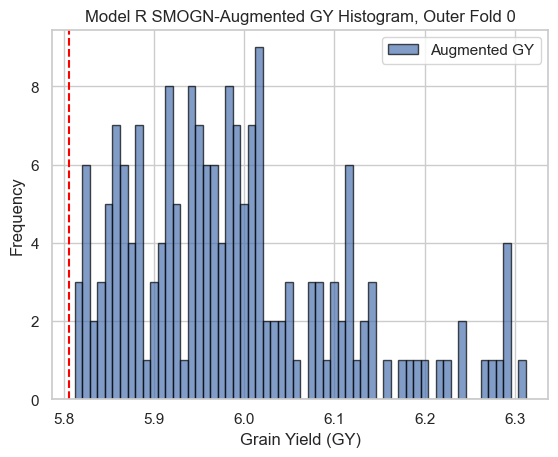

,GID6569128,GID6688880,GID6688916,GID6688933,GID6688934,GID6688949,GID6689407,GID6689482,GID6689550,GID6738288,...,GID6939900,GID6939902,GID6939903,GID6939904,GID6939917,GID6939919,GID6939938,GID6939941,GID6939945,GY
0,0.788801,-0.006443,0.025987,-0.138795,-0.157880,0.096213,-0.110899,0.013069,-0.040445,0.007931,...,0.133808,0.137456,0.127674,0.130468,0.004096,0.091188,0.074009,0.032992,0.199459,5.160521
1,-0.006443,0.980542,0.064585,-0.168773,-0.081006,0.078890,-0.201346,0.124671,0.253505,0.013636,...,0.061650,0.057898,0.079085,0.061086,0.104630,0.113878,0.108757,0.154718,0.004447,5.988963
2,-0.138795,-0.168773,-0.021636,0.879004,0.443678,-0.080560,0.402479,-0.218803,-0.102718,-0.002303,...,-0.087824,-0.089912,-0.067028,-0.084206,-0.140529,-0.088961,-0.096740,-0.159136,-0.108800,5.434369
3,-0.157880,-0.081006,-0.031717,0.443678,0.996666,-0.140766,0.395843,-0.310471,-0.138902,0.088169,...,-0.017375,-0.026372,-0.014478,-0.016350,-0.098509,-0.052304,-0.012778,-0.100318,-0.154557,5.551610
4,0.096213,0.078890,0.101532,-0.080560,-0.140766,0.942013,-0.064273,0.116772,0.071070,-0.016037,...,0.094683,0.093677,0.097538,0.099849,0.048248,0.139241,0.058980,0.045545,0.152167,5.459668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,0.127674,0.079085,0.408326,-0.067028,-0.014478,0.097538,-0.186001,0.034795,-0.048967,0.136133,...,1.180574,1.163339,1.229832,1.142452,0.150037,0.242206,0.708062,0.432339,0.639670,5.468315
608,0.130468,0.061086,0.426844,-0.084206,-0.016350,0.099849,-0.191481,0.034453,-0.045460,0.136212,...,1.170088,1.157341,1.142452,1.266578,0.161459,0.253641,0.704652,0.435412,0.649749,5.307925
609,0.074009,0.108757,0.240468,-0.096740,-0.012778,0.058980,-0.149919,0.000392,0.063573,0.090066,...,0.728707,0.732558,0.708062,0.704652,0.107666,0.159823,1.118190,0.388284,0.389739,5.487924
610,0.032992,0.154718,0.255337,-0.159136,-0.100318,0.045545,-0.206353,0.194754,0.043889,0.084022,...,0.461691,0.473004,0.432339,0.435412,0.121171,0.380622,0.388284,1.070441,0.219306,5.332815


dist_matrix:  62%|######2   | 76/122 [00:56<00:34,  1.33it/s]


KeyboardInterrupt: 

In [18]:

# Define hyperparameter grids for SVM regression model and conduct 2-dimensional cross-validation
x_params_SVM_R = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_R = mdo.AxisParams('C', bmo.power_list(2, -2, 6))
metrics_SVM_R = outer_CV_R(n_outer_splits=5, 
                           n_inner_splits=10, 
                           X=X, 
                           y=y,
                           axis1_params=x_params_SVM_R, 
                           axis2_params=y_params_SVM_R, 
                           train_model_callback=bmo.train_SVM_regressor, 
                           smogn_preprocess=SMOGN_PREPROCESS,
                           random_state=RANDOM_STATE, 
                           top_boundary_val=top_boundary_val, 
                           undersamp_ratio=0.5,
                           oversamp_ratio=1,
                           kernel='rbf')

"""
# Dummy values - Uncomment for quick debugging tests  
x_params_SVM_R = mdo.AxisParams('gamma', bmo.power_list(2, -1, 0))  
y_params_SVM_R = mdo.AxisParams('C', bmo.power_list(2, 1, 2))  
metrics_SVM_R = outer_CV_R(n_outer_splits=2,   
                           n_inner_splits=2,   
                           X=X, 
                           y=y,
                           axis1_params=x_params_SVM_R, 
                           axis2_params=y_params_SVM_R, 
                           train_model_callback=bmo.train_SVM_regressor, 
                           smogn_preprocess=SMOGN_PREPROCESS,
                           undersample=UNDERSAMPLE,
                           kfold_random_state=RANDOM_STATE, 
                           top_boundary_val=top_boundary_val, 
                           kernel='rbf')  
  """

In [ ]:
# Display classification metrics for best model from each outer fold
display(metrics_SVM_R)

In [ ]:
# Save average of each metric
metrics_SVM_R_mean = metrics_SVM_R.mean().to_frame().T
R_average_metrics.loc['SVM'] = metrics_SVM_R_mean.iloc[0]
display(metrics_SVM_R_mean)

## XGBoost

In [ ]:

# Test values
x_params_XGB_R = mdo.AxisParams('n_estimators', [13, 25, 50, 100, 200])
y_params_XGB_R = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16])
metrics_XGB_R = outer_CV_R(n_outer_splits=5, 
                           n_inner_splits=10, 
                           X=X, 
                           y=y,  
                           axis1_params=x_params_XGB_R, 
                           axis2_params=y_params_XGB_R, 
                           train_model_callback=bmo.train_XGB_regressor, 
                           smogn_preprocess=SMOGN_PREPROCESS,
                           undersample_ratio=UNDERSAMPLE,
                           random_state=RANDOM_STATE, 
                           top_boundary_val=top_boundary_val, 
                           objective="reg:squarederror", eval_metric="rmse")


"""
# Dummy values for quick debugging tests
x_params_XGB_R = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_R = mdo.AxisParams('max_depth', [1, 2])
metrics_XGB_R = outer_CV_R(2, 2,  
                           X=X, 
                           y=y,  
                           axis1_params=x_params_XGB_R, 
                           axis2_params=y_params_XGB_R, 
                           train_model_callback=bmo.train_XGB_regressor, 
                           smogn_preprocess=SMOGN_PREPROCESS,
                           undersample=UNDERSAMPLE,
                           kfold_random_state=RANDOM_STATE, 
                           top_boundary_val=top_boundary_val, 
                           objective="reg:squarederror", eval_metric="rmse")
"""

In [ ]:
# Display classification metrics for best model from each outer fold
display(metrics_XGB_R)

In [ ]:
# Print average of each metric and store results for analysis
metrics_XGB_R_mean = metrics_XGB_R.mean().to_frame().T
display(metrics_XGB_R_mean)
R_average_metrics.loc['XGB'] = metrics_XGB_R_mean.iloc[0]

In [ ]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_R.db')

# Model B

In [ ]:
def inner_CV_B(n_splits: int, X : pd.DataFrame, y_bin : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, 
               train_model_callback, kfold_random_state: int, classification_col : int, plot_title: str = "", 
               **kwargs):
    """
    Perform inner cross-validation to tune model hyperparameters and find the optimal classification threshold.
    Created: 2024/12/04
    Parameters:
    n_splits (int): Number of splits for KFold cross-validation.
    X (pd.DataFrame): Feature data.
    y (pd.DataFrame): Target data.
    axis1_params (mdo.AxisParams): Object containing hyperparameter values for the first (horizontal) axis.
    axis2_params (mdo.AxisParams): Object containing hyperparameter values for the second (vertical) axis.
    train_model_callback (function): Callback function to train the model.
    kfold_random_state (int): Random state for KFold shuffling.
    classification_col (int): Column index to pull classification probabilities from - 0 for not top, 1 for top.
    top_thresh_quantile (float): Threshold to classify predictions as top or not top.
    plot_title (str, optional): Title for the ROC plot. Defaults to "".
    **kwargs: Additional arguments for the train_model_callback function.
    Returns:
    tuple: Average best parameters (param1, param2) and the best classification threshold.
    """
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Arrays to store parameters and binary classification thresholds of the most accurate model for each inner fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_bin_train, y_bin_test = y_bin.iloc[train_index], y_bin.iloc[test_index]

        # Train a grid of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_bin_train, axis1_params, axis2_params, train_model_callback, **kwargs)
        
        # Use trained models to predict test set probabilities, and store in a 2D array with each cell corresponding to a model with a specific combination of parameters
        y_proba_preds_grid = bmo.grid_predict_proba(X_test, model_grid, classification_col)

        # Use probabilities to classify predictions as top or not top. This isn't the final classification, 
        # but a step towards finding the optimal threshold, so we just use the default 0.5 threshold for now.
        y_binary_preds_grid = bmo.continuous_to_binary_absolute_grid(y_proba_preds_grid, 0.5)

        # Create a 2D array of identical dataframes containing actual labels to compare against predictions
        y_bin_test_grid = cdt.np_array_of_dfs(y_bin_test, y_proba_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating a 2D array of F1 scores.
        f1_grid = bmo.calculate_f1_scores(y_binary_preds_grid, y_bin_test_grid)

        # Find the index of the best F1 score in the 2D array of F1 scores
        best_row, best_col = np.unravel_index(np.argmax(f1_grid), f1_grid.shape)

        # Store hyperparameters of the most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]

        # Find the classification probability threshold between zero and one that yields the lowest squared difference between sensitivity and 
        # specificity using this optimal model. To do this, we feed find_optimal_threshold() the probabilities predicted by the model, not the binary predictions.
        best_model_proba_preds = y_proba_preds_grid[best_row, best_col]
        best_thresholds.iloc[i, 0] = bmo.find_optimal_threshold_absolute(y_bin_test, best_model_proba_preds)

        # Create a grid of ROC plots with predictions vs actuals, colored by F1 score for each model
        roc_grid = plot_shaded_roc_grids(y_proba_preds_grid, y_bin_test_grid, axis1_params, axis2_params, f1_grid, f'{plot_title} | Inner Fold {i}')        
        plt.savefig(f'{storage_dir}\\model_B, {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")

        plt.show(roc_grid)
        plt.close(roc_grid)

    # Calculate average best parameters over all inner folds to return to outer CV
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # Calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold


In [ ]:
def outer_CV_B(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, 
               axis1_params: mdo.AxisParams, 
               axis2_params: mdo.AxisParams, train_model_callback : callable, random_state: int, 
               classification_col : int, top_boundary_val : float, smote_preprocess = False, undersamp_ratio=1, **kwargs) -> pd.DataFrame:
    """
    Perform nested cross-validation with an outer and inner loop to evaluate model B performance.
    Created: 2024/12/29
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation.
    n_inner_splits : int
        Number of splits for the inner cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object representing hyperparameter search space for the first axis.
    axis2_params : mdo.AxisParams
        Object representing hyperparameter search space for the second axis.
    train_model_callback : callable
        Function to train the model.
    kfold_random_state : int
        Random state for reproducibility in KFold.
    classification_col : int
        Column index to pull classification probabilities from - 0 for not top, 1 for top.
    top_line_thresh : float
        Threshold to classify predictions as top or not top.
    **kwargs : dict
        Additional parameters for the model training function.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the metrics for each outer fold, including F1 Score, Sensitivity, Specificity, and Kappa.
    """
    
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=random_state)

    # Store metrics of best model for each fold
    kfold_metrics = pd.DataFrame(columns=['F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        y_train_bin = bmo.continuous_to_binary_absolute(y_train, top_boundary_val)
        y_test_bin = bmo.continuous_to_binary_absolute(y_test, top_boundary_val)

        if smote_preprocess:
            sm = SMOTE(random_state=random_state)
            X_train, y_train_bin = sm.fit_resample(X_train, y_train_bin)

            # Split the top and not top lines into seperate dataframes
            y_train_top = y_train_bin[y_train_bin == 1]
            X_train_top = X_train.loc[y_train_top.index]
            y_train_not_top = y_train_bin[y_train_bin == 0]
            X_train_not_top = X_train.loc[y_train_not_top.index]

            # Undersample the majority class so that it is a certain proportion of its original size
            X_train_not_top_us, y_train_not_top_us = cdt.random_subset(X_train_not_top, y_train_not_top, p=undersamp_ratio, random_state=random_state)

            # Re-combine the top and not top line data
            X_train = pd.concat([X_train_top, X_train_not_top_us], axis=0)
            y_train = pd.concat([y_train_top, y_train_not_top_us], axis=0)
        
        X_train, _, X_scaler, _ = scale_features_and_target(X_train, None)
        X_test = X_scaler.transform(X_test)

        # Find average best parameters and threshold based on F1 score using inner-fold CV
        best_param1, best_param2, best_threshold = inner_CV_B(n_inner_splits, X_train, y_train_bin, axis1_params, axis2_params, train_model_callback, random_state, classification_col, plot_title=f"Outer Fold {i}", **kwargs)

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train, np.ravel(y_train_bin), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # Use trained "super-model" to predict test set probabilities
        y_pred_proba = pd.DataFrame(super_model.predict_proba(X_test)[:, classification_col], index=y_test_bin.index, columns=y_test_bin.columns)
        histogram(y_pred_proba, f'Top Line Probability Histogram, {train_model_callback.__name__}, Outer Fold {i}', x_ax_label='Top Line Probability')

        # Classify predictions and actuals of super_model as top or not top (boolean) using the best threshold as determined by inner CV
        y_pred_bin = bmo.continuous_to_binary_absolute(y_pred_proba, best_threshold)

        # Plot ROC and PR curves using seaborn
        cmp.sns_plot_roc_curve(pd.DataFrame(y_test_bin), pd.DataFrame(y_pred_proba), f'Model B ROC Curve, {train_model_callback.__name__}, Outer Fold {i}')
        plt.savefig(f'{storage_dir}\\Model B ROC Curve, {train_model_callback.__name__}, Outer Fold {i}.svg', format="svg")
        plt.show()
        plt.close()

        cmp.sns_plot_pr_curve(pd.DataFrame(y_test_bin), pd.DataFrame(y_pred_proba), f'Model B PR Curve, {train_model_callback.__name__}, Outer Fold {i}')
        plt.savefig(f'{storage_dir}\\Model B PR Curve, {train_model_callback.__name__}, Outer Fold {i}.svg', format="svg")
        plt.show()
        plt.close()
    
        # Calculate classification metrics and add new row to kfold_metrics   
        classification_metrics = cdt.classification_metrics(y_pred_bin, y_test_bin)   
        kfold_metrics = pd.concat([kfold_metrics, classification_metrics], axis=0)   

    # Label each row of kfold_metrics with the fold number
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics


## SVM

In [ ]:

# Define hyperparameter grids for SVM classification model and conduct 2-dimensional cross-validation
x_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -18, -8))
y_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, 2, 16))
metrics_SVM_B = outer_CV_B(5, 10, X, y, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, 
                           random_state=RANDOM_STATE, classification_col=1, top_boundary_val=top_boundary_val, 
                           smote_preprocess=SMOGN_PREPROCESS, probability=True, kernel='rbf')

"""
# Dummy values for tests
x_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -10, -9))
y_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
metrics_SVM_B = outer_CV_B(2, 2, X, y, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, kfold_random_state=RANDOM_STATE, kernel='rbf', classification_col=1, top_boundary_val=top_boundary_val, probability=True)
"""

In [ ]:
# Display classification metrics for super-model trained on all data from each outer fold
display(metrics_SVM_B)

In [ ]:
# Print average of each metric
metrics_SVM_B_mean = metrics_SVM_B.mean().to_frame().T
B_average_metrics.loc['SVM'] = metrics_SVM_B_mean.iloc[0]
display(metrics_SVM_B_mean)

## XGBoost

In [ ]:
# Define hyperparameter grids for XGB classification model and conduct 2-dimensional cross-validation
x_params_XGB_B = mdo.AxisParams('n_estimators', [3, 7, 13, 25, 50, 100, 200, 400])
y_params_XGB_B = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16, 32, 64])
metrics_XGB_B = outer_CV_B(5, 10, X, y, x_params_XGB_B, y_params_XGB_B, bmo.train_XGB_classifier, random_state=RANDOM_STATE, 
                           classification_col=1, top_boundary_val=top_boundary_val, smote_preprocess=SMOGN_PREPROCESS, 
                           objective="binary:logistic", eval_metric="logloss")

"""
# Dummy values for quick tests
x_params_XGB_B = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_B = mdo.AxisParams('max_depth', [1, 2])
metrics_XGB_B = outer_CV_B(2, 2, X, y, x_params_XGB_B, y_params_XGB_B, bmo.train_XGB_classifier, random_state=RANDOM_STATE, 
                           classification_col=1, top_boundary_val=top_boundary_val, smote_preprocess=SMOGN_PREPROCESS, 
                           objective="binary:logistic", eval_metric="logloss")"""

In [ ]:
display(metrics_XGB_B)

In [ ]:
# Print average of each metric
metrics_XGB_B_mean = metrics_XGB_B.mean().to_frame().T
B_average_metrics.loc['XGB'] = metrics_XGB_B_mean.iloc[0]
display(metrics_XGB_B_mean)

In [ ]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_B.db')

# Model RO

In [ ]:
def inner_CV_RO(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, y_top_bound : float, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, 
                kfold_random_state: int, plot_title: str = "", **kwargs):
    """
    Perform inner cross-validation (RO) to find the best model parameters and classification threshold.
    Created: 2024/12/21
    Parameters:
    n_splits (int): Number of splits for K-Fold cross-validation.
    X (pd.DataFrame): Feature data.
    y (pd.DataFrame): Target data.
    axis1_params (mdo.AxisParams): Hyperparameters to explore for the horizontal axis.
    axis2_params (mdo.AxisParams): Hyperparameters to explore for the vertical axis.
    train_model_callback (callable): Callback function to train the model.
    kfold_random_state (int): Random state for K-Fold shuffling.
    top_line_threshold (float): Threshold to classify top values during intermediate step in inner CV.
    plot_title (str, optional): Title for the plot. Defaults to "".
    **kwargs: Additional keyword arguments for the model training callback.
    Returns:
    tuple: Average best parameters for axis1 and axis2, and the best classification threshold.
    """

    # Create KFold object for inner-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Store best parameters (param1, param2) for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train a grid of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # Use trained models to predict test set labels, and store in a 2D array with each cell corresponding to a model with a specific combination of parameters
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # Create a 2D array of identical dataframes containing actual labels to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating a 2D array of Pearson coefficients
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        # Find the index of the best Pearson coefficient in the 2D array of Pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # Store hyperparameters of the most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]

        # Extract best model's continuous predictions
        best_model_y_preds = y_preds_grid[best_row, best_col]

        # Classify labels as top or not top (boolean)
        y_test_binary = bmo.continuous_to_binary_absolute(y_test, y_top_bound)
        
        # Find classification threshold that yields the lowest squared difference between sensitivity and specificity using this optimal model
        best_absolute_thresh = bmo.find_optimal_threshold_absolute(y_test_binary, best_model_y_preds)
        best_thresholds.iloc[i, 0] = best_absolute_thresh

        # Create a grid of scatter plots with predictions vs actuals, colored by Pearson coefficient for each model
        scatter_grid = plot_shaded_scatter_grids(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, f'{plot_title} | Inner Fold {i}')        
        plt.savefig(f'{storage_dir}\\model_RO, {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")
        plt.show(scatter_grid)
        plt.close(scatter_grid)

    # Calculate average best parameters over all folds
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # Calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold


In [ ]:
def outer_CV_RO(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, 
                axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback : callable, 
                kfold_random_state: int, top_boundary_val : float, smogn_preprocess : bool = False, undersample : bool = True,
                **kwargs) -> (pd.DataFrame, list):
    """
    Perform outer cross-validation with nested inner cross-validation for model RO selection and evaluation.
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation.
    n_inner_splits : int
        Number of splits for the inner cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object representing hyperparameter search space for the first axis.
    axis2_params : mdo.AxisParams
        Object representing hyperparameter search space for the second axis.
    train_model_callback : callable
        Callback function to train the model.
    kfold_random_state : int
        Random state for reproducibility in KFold splitting.
    top_line_threshold : float
        Threshold for classifying top predictions during intermediate step in inner CV.
    **kwargs : dict
        Additional parameters for the model training callback.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the evaluation metrics for each outer fold, including Pearson correlation, F1 Score, Sensitivity, Specificity, and Kappa.
    list
        List of trained super_models for each outer fold.
    """

    # Create KFold object for outer loop to split data into train and test sets
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    # Initialize DataFrame to store evaluation metrics for each outer fold
    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])
    
    # Initialize list to store super_models for each outer fold
    super_models = []

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if smogn_preprocess:
            top_boundary_quantile_in_train_set = percentileofscore(y_train.to_numpy().flatten(), top_boundary_val, kind='mean') / 100

            # Store pre-SMOGN data for later use
            X_train_pre_smogn = X_train.copy()
            y_train_pre_smogn = y_train.copy()
            X_train, y_train = smogn_prep(X_train, y_train, top_boundary_quantile_in_train_set, undersample)

            if not undersample:
                # Manually concatenate the original data below the augmentation threshold with the augmented data
                non_augmented_indices = y_train_pre_smogn[y_train_pre_smogn < top_boundary_val].index
                X_train_non_augmented = X_train_pre_smogn.loc[non_augmented_indices]
                y_train_non_augmented = y_train_pre_smogn.loc[non_augmented_indices]
                X_train = pd.concat([X_train, X_train_non_augmented], axis=0)
                y_train = pd.concat([y_train, y_train_non_augmented], axis=0)

            # Split the augmented and original data into seperate columns for plotting
            original_data = pra.intersection(y_train_pre_smogn, y_train)
            augmented_data = pra.difference(y_train, original_data)
            orig_aug_data = pd.concat([original_data, augmented_data], axis=1)
            orig_aug_data.columns = ['Original GY', 'Augmented GY']

            histogram(orig_aug_data, f'Model RO SMOGN-Augmented GY Histogram, Outer Fold {i}', vline_value=top_boundary_val)
        else:
            histogram(y_train, f'Model RO Histogram, Outer Fold {i}', vline_value=top_boundary_val)


        # Scale features and target for the training data
        X_train, y_train, X_scaler, y_scaler = scale_features_and_target(X_train, y_train)
        # Scale the top boundary value
        top_boundary_val_scaled = y_scaler.transform([[top_boundary_val]])[0, 0]
        # Scale the test data using the same scaler as the training data
        X_test = pd.DataFrame(X_scaler.transform(X_test))
        X_test.columns = X.columns
        y_test = pd.DataFrame(y_scaler.transform(y_test))

        # Find average best parameters and threshold based on Pearson score using inner-fold CV
        best_param1, best_param2, best_threshold_fixed = inner_CV_RO(n_inner_splits, X_train, y_train, top_boundary_val_scaled, axis1_params, axis2_params, train_model_callback, kfold_random_state, plot_title=f"Outer Fold {i}", **kwargs)

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)
        
        # Append the trained super_model to the list
        super_models.append(super_model)

        # Use trained "super-model" to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test).reshape(-1, 1), index=y_test.index, columns=y_test.columns)
        # Plot histogram of the predicted values
        histogram(y_pred, f'Predicted GY Histogram, {train_model_callback.__name__}, Outer Fold {i}')

        # Calculate Pearson coefficient of continuous predictions
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # Classify predictions and actuals of super_model as top or not top (boolean)
        y_pred_top = bmo.continuous_to_binary_absolute(y_pred, best_threshold_fixed)
        y_test_top = bmo.continuous_to_binary_absolute(y_test, top_boundary_val_scaled)

        # Plot classification results
        cmp.plot_classification_results(y_pred, y_test, y_pred_top, y_test_top, 
                                [f"Model RO Predicted vs Actual GY, {train_model_callback.__name__}, Outer Fold {i}"],
                                save_path=f'{storage_dir}\\Model RO Super Model Predicted vs Actual GY, {train_model_callback.__name__}, Outer Fold {i}.svg')

        # Calculate classification metrics and add new row to kfold_metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)
    
    # Reset index of the metrics DataFrame

    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics, super_models

### SVM

In [ ]:

# Set hyperparameter grids for SVM regression model and conduct 2-dimensional cross-validation
x_params_SVM_RO = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_RO = mdo.AxisParams('C', bmo.power_list(2, -2, 6))
metrics_SVM_RO, RO_SVM_models = outer_CV_RO(5, 10, X, y, x_params_SVM_RO, y_params_SVM_RO, bmo.train_SVM_regressor, 
                             kfold_random_state=RANDOM_STATE, top_boundary_val=top_boundary_val, smogn_preprocess=SMOGN_PREPROCESS, 
                            undersample=UNDERSAMPLE, kernel='rbf')

"""
# Quick test values
x_params_SVM_RO = mdo.AxisParams('gamma', bmo.power_list(2, -8, -7))
y_params_SVM_RO = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
metrics_SVM_RO, RO_SVM_models = outer_CV_RO(2, 2, X, y, x_params_SVM_RO, y_params_SVM_RO, bmo.train_SVM_regressor, 
                             kfold_random_state=RANDOM_STATE, top_boundary_val=top_boundary_val, smogn_preprocess=SMOGN_PREPROCESS, 
                             undersample=UNDERSAMPLE, kernel='rbf')"""

In [ ]:
if SHAP:
    # Create a background dataset (using ~25% of data)
    n_background = 200  # 25% of 800 points
    background_data = shap.sample(X, n_background, random_state=42)  # Using random sampling for better representation

    # Create the SHAP explainer with the correct parameters
    explainer = shap.KernelExplainer(RO_SVM_models[0].predict, background_data)
    shap_values = explainer.shap_values(X)

    # Create the summary plot
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.savefig(f'{storage_dir}\\SHAP Summary Plot, SVM, Outer Fold 0.svg', format="svg")
    plt.show()
    plt.close()

In [ ]:
display(metrics_SVM_RO)

In [ ]:
# Print average of each metric
metrics_SVM_RO_mean = metrics_SVM_RO.mean().to_frame().T
RO_average_metrics.loc['SVM'] = metrics_SVM_RO_mean.iloc[0]
display(metrics_SVM_RO_mean)

## XGBoost

In [ ]:
# Define hyperparameter grids for XGB regression model and conduct 2-dimensional cross-validation
x_params_XGB_RO = mdo.AxisParams('n_estimators', [3, 7, 13, 25, 50, 100, 200])
y_params_XGB_RO = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16, 32, 64])
metrics_XGB_RO, RO_XGB_models = outer_CV_RO(5, 10, X, y, x_params_XGB_RO, y_params_XGB_RO, bmo.train_XGB_regressor, 
                             kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, top_boundary_val=top_boundary_val, 
                             smogn_preprocess=SMOGN_PREPROCESS, undersample=UNDERSAMPLE, objective="reg:squarederror", 
                             eval_metric="rmse")
"""
# Quick test values
x_params_XGB_RO = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_RO = mdo.AxisParams('max_depth', [1, 2])
metrics_XGB_RO, RO_XGB_models = outer_CV_RO(2, 2, X, y, x_params_XGB_RO, y_params_XGB_RO, bmo.train_XGB_regressor, 
                                kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, top_boundary_val=top_boundary_val, 
                                smogn_preprocess=SMOGN_PREPROCESS, undersample=UNDERSAMPLE, objective="reg:squarederror", 
                                eval_metric="rmse")
"""

In [ ]:
if SHAP:
    # Create a background dataset (using ~25% of data)
    n_background = 200  # 25% of 800 points
    background_data = shap.sample(X, n_background, random_state=42)

    # Create a wrapper function for the model's predict method
    def model_predict(x):
        return RO_XGB_models[0].predict(x)

    # Create the SHAP explainer with the wrapper function
    explainer = shap.KernelExplainer(model_predict, background_data)
    shap_values = explainer.shap_values(X)

    # Create the summary plot
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.savefig(f'{storage_dir}\\SHAP Summary Plot, SVM, Outer Fold 0.svg', format="svg")
    plt.show()
    plt.close()

In [ ]:
display(metrics_XGB_RO)

In [ ]:
# Print average of each metric
metrics_XGB_RO_mean = metrics_XGB_RO.mean().to_frame().T
RO_average_metrics.loc['XGB'] = metrics_XGB_RO_mean.iloc[0]
display(metrics_XGB_RO_mean)

In [ ]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_RO.db')

# Conclusion

In [ ]:
# Plot average metrics for each model to compare GBLUP, SVM, and XGB
R_avg_metrics_plot = cmp.plot_model_metrics(R_average_metrics, "R")
R_avg_metrics_plot.savefig(f'{storage_dir}\\R_avg_metrics_plot.svg', format='svg')
plt.show(R_avg_metrics_plot)
plt.close(R_avg_metrics_plot)

B_avg_metrics_plot = cmp.plot_model_metrics(B_average_metrics, "B")
B_avg_metrics_plot.savefig(f'{storage_dir}\\B_avg_metrics_plot.svg', format='svg')
plt.show(B_avg_metrics_plot)
plt.close(B_avg_metrics_plot)

RO_avg_metrics_plot = cmp.plot_model_metrics(RO_average_metrics, "RO")
RO_avg_metrics_plot.savefig(f'{storage_dir}\\RO_avg_metrics_plot.svg', format='svg')
plt.show(RO_avg_metrics_plot)
plt.close(RO_avg_metrics_plot)